In [1]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from paths import *
import numpy as np
import pandas as pd

In [2]:
model = joblib.load(os.path.join(OUTPUT_PATH, "GLM_global_compounds_without_outlier_sample_serum_feces_ratio.joblib"))

model_list = [model]
model_name_list = ["Without outlier"]


In [3]:
sheet_name = ["Chemical Annotation", "Sample Meta Data", "Log Transformed Data"]

file_path = os.path.join(DATA_ROOT_PATH, GLOBAL_STOOL_DATA_FILENAME)
analyte_metadata_feces = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[0])

file_path = os.path.join(DATA_ROOT_PATH, GLOBAL_SERUM_DATA_FILENAME)
analyte_metadata_serum = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[0])

analyte_metadata = pd.concat([analyte_metadata_serum, analyte_metadata_feces], ignore_index=True).drop_duplicates(subset=["CHEM_ID", "CHEMICAL_NAME"])


In [37]:
# Note: Certain analytes have their GLM model as None. 
# This is because those analytes' concentration values were constant across all patient samples.

disease_coeff = []
none_model_index = []
pval_thresh = 0.05

for index, model in enumerate(model_list):
    disease_coeff_model = []
    for item in model:
        try:
            if (item["model"].pvalues["Disease_label"] < pval_thresh) & (item["model"].converged==1):
                disease_coeff_model.append(item["model"].params["Disease_label"])
            else:
                disease_coeff_model.append(None)        
        except:
            none_model_index.append({"model": item, "model_index":index})                        
            disease_coeff_model.append(None)
    disease_coeff.append(disease_coeff_model)
    
analyte_list = []
for item in model:    
    analyte_list.append(analyte_metadata[analyte_metadata["CHEM_ID"] == item["analyte"]]["CHEMICAL_NAME"].values[0])
    
disease_coeff = np.array(disease_coeff).transpose()
disease_coeff[disease_coeff == None] = np.nan
disease_coeff = np.where(disease_coeff == None, np.nan, disease_coeff).astype(float)
disease_coeff_df = pd.DataFrame(disease_coeff, index=analyte_list, columns=model_name_list)
disease_coeff_df.dropna(inplace=True)
disease_coeff_df.reset_index(inplace=True)
disease_coeff_df.rename(columns={"index":"analyte_name", "Without outlier":"disease_coeff"}, inplace=True)


In [38]:
disease_coeff_df_negative = disease_coeff_df[disease_coeff_df.disease_coeff < 0]
disease_coeff_df_positive = disease_coeff_df[disease_coeff_df.disease_coeff > 0]
disease_coeff_df_negative_top = disease_coeff_df_negative.sort_values(by="disease_coeff", ascending=True).head(10)
disease_coeff_df_positive_top = disease_coeff_df_positive.sort_values(by="disease_coeff", ascending=False).head(10)
sorted_df = pd.concat([disease_coeff_df_positive_top, disease_coeff_df_negative_top], ignore_index=True)


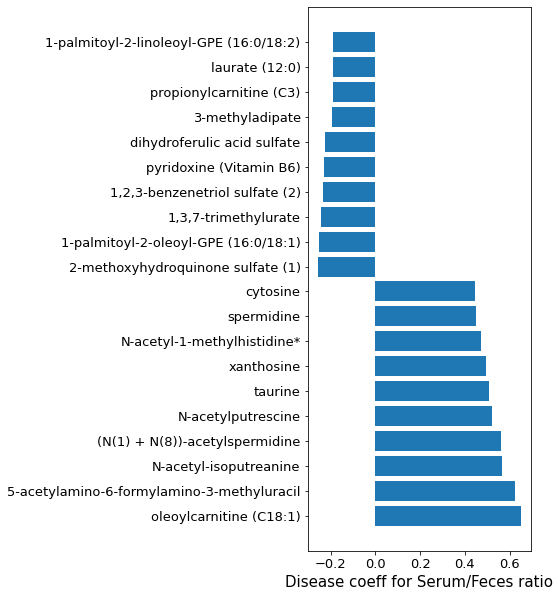

Saving the figure ...


In [40]:
FIG_SIZE = (4, 10)
FONTSIZE = 13
LABELSIZE = 15

filename_suffix_list = ["combined_population", "ms_treated_population", "ms_not_treated_population"]

fig, ax = plt.subplots(figsize=FIG_SIZE)
plt.barh(sorted_df["analyte_name"], sorted_df["disease_coeff"])
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('Disease coeff for Serum/Feces ratio', fontsize=LABELSIZE)
# plt.ylabel('Analyte name', fontsize=LABELSIZE)
plt.show()

print('Saving the figure ...')
fig_filename = os.path.join(OUTPUT_PATH, "figures", "disease_coeff_plot_for_the_serum_feces_ratio_for_global_compounds_using_combined_population.svg")
fig.savefig(fig_filename, format='svg', bbox_inches='tight')

